# Extract annotation information from UniProt

Note: Requires internet connection to download information from the [Universal Protein Resource (UniProt)](https://www.uniprot.org/).
*  [UniProt Knowledgebase (UniProtKB)](https://www.uniprot.org/help/uniprotkb)

## Setup
### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from rbc_gem_utils import (
    ROOT_PATH,
    DATABASE_PATH,
    ANNOTATION_PATH,
    INTERIM_PATH,
    GEM_NAME,
    read_rbc_model,
    get_annotation_df,
    compare_tables,
    split_string,
    build_string,
    visualize_comparison,
    check_database_version_online,
    check_version,
    show_versions,
)

from rbc_gem_utils.database.uniprot import (
    UNIPROT_VERSION_EXPECTED,
    UNIPROT_DB_TAG,
    get_version_UniProt,
    query_UniProt,
    get_annotation_to_from_db_UniProt,
    get_label_miriam_mapping_UniProt,
    get_query_fields_UniProt,
    parse_isoforms_UniProt,
    parse_chains_UniProt,
    get_isoform_value_from_entry_UniProt,
)


# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Check UniProt version
If the version does not match the expected version, it is because database has been updated since the last time this code was utilized. 

### Expected UniProt version: 2024_01
* According to [UniProt](https://www.uniprot.org/help/downloads), updates to the database are made every eight weeks. 
* Last release utilized: [2024_01](https://www.uniprot.org/uniprotkb/statistics) published on **Wed Jan 24 2024**.

In [2]:
if not check_database_version_online("UniProt"):
    warn(
        "Online version of database has been updated since the last time notebook was used."
    )

version = get_version_UniProt()
if check_version(version, UNIPROT_VERSION_EXPECTED, verbose=True):
    database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
else:
    # Use different directory paths for unexpected behavior
    database_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"
annotation_to_from_db = get_annotation_to_from_db_UniProt(miriam_only=True)

Current and expected versions match.


## Load RBC-GEM model

In [3]:
model = read_rbc_model(filetype="xml")
model

Name,RBC_GEM
Memory address,14c721a90
Number of metabolites,1984
Number of reactions,2823
Number of genes,693
Number of groups,76
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Download data from UniProt

### Get IDs for query
#### Using an existing annotation

In [4]:
annotation_type = "genes"
df_model_mappings = get_annotation_df(
    getattr(model, annotation_type), ["uniprot", "ncbigene"]
).rename({"id": annotation_type}, axis=1)

for col in df_model_mappings.columns:
    df_model_mappings[col] = df_model_mappings[col].apply(split_string)
    df_model_mappings = df_model_mappings.explode(col)
print(df_model_mappings.nunique(dropna=True))
df_model_mappings

genes       693
uniprot     693
ncbigene    697
dtype: int64


,genes,uniprot,ncbigene
0,RPE,Q96AT9,6120
1,RPIA,P49247,22934
2,SORD,Q00796,6652
3,AKR7A2,O43488,8574
4,SRM,P19623,6723
...,...,...,...
688,SLC9B2,Q86UD5,133308
689,SMPD1,P17405,6609
690,SPHK1,Q9NYA1,8877
691,TRPC6,Q9Y210,7225


In [5]:
annotation_key = "uniprot"

from_db = annotation_to_from_db[annotation_key]
query_ids = df_model_mappings[annotation_key].dropna().unique()
assert len(set(query_ids)) == len(query_ids), "Duplicate IDs in list to query"
model_search_mapping = df_model_mappings.set_index(annotation_type)[
    annotation_key
].to_dict()
print(f"Number of model genes associated with query: {len(model_search_mapping)}")
print(f"Number of unique IDs to query: {len(query_ids)}")
df_model_mappings[[annotation_type, annotation_key]].drop_duplicates()

Number of model genes associated with query: 693
Number of unique IDs to query: 693


,genes,uniprot
0,RPE,Q96AT9
1,RPIA,P49247
2,SORD,Q00796
3,AKR7A2,O43488
4,SRM,P19623
...,...,...
688,SLC9B2,Q86UD5
689,SMPD1,P17405
690,SPHK1,Q9NYA1
691,TRPC6,Q9Y210


### Set universal query parameters

In [6]:
miriam_query_fields = get_query_fields_UniProt(miriam_only=True)
query_fields = miriam_query_fields + [
    # Add additional non-miriam fields if desired
    "xref_proteomes"
]

In [7]:
query_fields

['accession',
 'gene_primary',
 'organism_id',
 'cc_alternative_products',
 'ec',
 'rhea',
 'uniparc_id',
 'go_id',
 'ft_chain',
 'lit_pubmed_id',
 'xref_ccds',
 'xref_embl',
 'xref_refseq',
 'xref_bmrb',
 'xref_pdb',
 'xref_sasbdb',
 'xref_smr',
 'xref_biogrid',
 'xref_corum',
 'xref_complexportal',
 'xref_dip',
 'xref_elm',
 'xref_intact',
 'xref_mint',
 'xref_string',
 'xref_bindingdb',
 'xref_chembl',
 'xref_drugbank',
 'xref_drugcentral',
 'xref_guidetopharmacology',
 'xref_swisslipids',
 'xref_allergome',
 'xref_cazy',
 'xref_ideal',
 'xref_merops',
 'xref_peroxibase',
 'xref_rebase',
 'xref_tcdb',
 'xref_depod',
 'xref_phosphositeplus',
 'xref_dbsnp',
 'xref_compluyeast-2dpage',
 'xref_epd',
 'xref_massive',
 'xref_maxqb',
 'xref_pride',
 'xref_paxdb',
 'xref_peptideatlas',
 'xref_proteomicsdb',
 'xref_ensembl',
 'xref_ensemblbacteria',
 'xref_ensemblfungi',
 'xref_ensemblmetazoa',
 'xref_ensemblplants',
 'xref_ensemblprotists',
 'xref_geneid',
 'xref_gramene',
 'xref_kegg',
 'x

In [8]:
# Extract all relevant information for now and save
query_parameters = {
    "query": " && ".join(
        [
            "(reviewed:true)",
            "(organism_id:9606)",  # Homo sapiens (Human)
        ]
    ),
    "format": "tsv",
    "size": 500,
    "compressed": True,
    "fields": ",".join(query_fields),
}

## Run queries

In [9]:
compare_figsize = (5, 20)
compare = True
display_nunique = True
overwrite = True


all_query_results = {}

### Initial query

In [10]:
query_key = "initial"
df_results, uniparc, failed_ids, obselete_counts = query_UniProt(
    list(query_ids),
    query_parameters=query_parameters,
    to_db="UniProtKB",
    from_db=from_db,
    return_failed=True,
)
if failed_ids:
    print(failed_ids)
all_query_results[query_key] = df_results
df_results

Fetched: 500 / 693
Fetched: 693 / 693


,From,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology IDs,Chain,...,HAMAP,InterPro,PANTHER,Pfam,PIRSF,PRINTS,PROSITE,SMART,SUPFAM,Proteomes
0,A0AVT1,A0AVT1,UBA6,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,6.2.1.45,,UPI000004A4F7,GO:0004792; GO:0004839; GO:0005524; GO:0005737...,"CHAIN 1..1052; /note=""Ubiquitin-like modifier-...",...,,IPR032420;IPR032418;IPR042302;IPR045886;IPR000...,PTHR10953:SF162;PTHR10953;,PF16191;PF16190;PF09358;PF00899;PF10585;,,PR01849;,,SM00985;,SSF69572;,UP000005640: Chromosome 4
1,A6NDG6,A6NDG6,PGP,9606,ALTERNATIVE PRODUCTS:,3.1.3.21; 3.1.3.48,RHEA:10684 RHEA:46084 RHEA:66372,UPI00000473F8,GO:0000121; GO:0000287; GO:0004725; GO:0005737...,"CHAIN 1..321; /note=""Glycerol-3-phosphate phos...",...,,IPR036412;IPR006357;IPR023214;IPR006349;,PTHR19288;PTHR19288:SF92;,PF13344;PF13242;,PIRSF000915;,,,,SSF56784;,UP000005640: Chromosome 16
2,A6NFX1,A6NFX1,MFSD2B,9606,ALTERNATIVE PRODUCTS:,,RHEA:38667 RHEA:38671 RHEA:70207,UPI000047F9C2,GO:0003376; GO:0005886; GO:0006869; GO:0008643...,"CHAIN 1..504; /note=""Sphingosine-1-phosphate t...",...,,IPR039672;IPR036259;,PTHR11328;PTHR11328:SF30;,PF13347;,,,,,SSF103473;,UP000005640: Chromosome 2
3,O00154,O00154,ACOT7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.2.2,RHEA:16645 RHEA:30143 RHEA:30135 RHEA:40139 RH...,UPI000012674F,GO:0000062; GO:0005654; GO:0005739; GO:0005829...,"CHAIN 1..380; /note=""Cytosolic acyl coenzyme A...",...,,IPR040170;IPR033120;IPR029069;IPR006683;,PTHR11049;PTHR11049:SF27;,PF03061;,,,PS51770;,,SSF54637;,UP000005640: Chromosome 1
4,O00299,O00299,CLIC1,9606,ALTERNATIVE PRODUCTS:,,,UPI000011785A,GO:0005254; GO:0005615; GO:0005634; GO:0005635...,"CHAIN 2..241; /note=""Chloride intracellular ch...",...,,IPR002946;IPR030259;IPR010987;IPR036282;IPR040...,PTHR45476:SF2;PTHR45476;,PF13410;PF13409;,,PR01263;,PS50405;,,SSF47616;SSF52833;,UP000005640: Chromosome 6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,Q9Y666,Q9Y666,SLC12A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,,RHEA:72427,UPI0000141815,GO:0005886; GO:0006811; GO:0006884; GO:0007268...,"CHAIN 1..1083; /note=""Solute carrier family 12...",...,,IPR004841;IPR000076;IPR018491;IPR004842;,PTHR11827:SF47;PTHR11827;,PF00324;PF03522;,,PR01081;,,,,UP000005640: Chromosome 5
689,Q9Y694,Q9Y694,SLC22A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,,RHEA:72043 RHEA:76207 RHEA:76211 RHEA:76215 RH...,UPI000006F307,GO:0005829; GO:0005886; GO:0006805; GO:0006811...,"CHAIN 1..548; /note=""Solute carrier family 22 ...",...,,IPR011701;IPR020846;IPR036259;IPR004749;,PTHR24064;PTHR24064:SF33;,PF07690;,,,PS50850;,,SSF103473;,UP000005640: Chromosome 6
690,Q9Y696,Q9Y696,CLIC4,9606,ALTERNATIVE PRODUCTS:,,,UPI0000127AC9,GO:0001525; GO:0001886; GO:0005254; GO:0005737...,"CHAIN 2..253; /note=""Chloride intracellular ch...",...,,IPR002946;IPR010987;IPR036282;IPR040079;IPR004...,PTHR45476:SF5;PTHR45476;,PF13409;,,PR01263;,PS50405;,,SSF47616;SSF52833;,UP000005640: Chromosome 1
691,Q9Y6M4,Q9Y6M4,CSNK1G3,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.11.1,RHEA:17989 RHEA:46608,UPI000035B1BD,GO:0004672; GO:0004674; GO:0005524; GO:0005634...,"CHAIN 1..447; /note=""Casein kinase I isoform g...",...,,IPR022247;IPR011009;IPR000719;IPR017441;IPR008...,PTHR11909:SF151;PTHR11909;,PF12605;PF00069;,,,PS00107;PS50011;PS00108;,SM00220;,SSF56112;,UP000005640: Chromosome 5


### Address failed IDs


In [11]:
# retry_ids = {}
# query_key = "retry_1"
# df_results, failed_ids = query_UniProt(
#     list(sorted(retry_ids.values())),
#     from_db="UniProtKB",
#     query_parameters=query_parameters
# )
# if failed_ids:
#     print(failed_ids)
# all_query_results[query_key] = df_results
# model_search_mapping.update({
#     k: retry_ids[v] for k, v in model_search_mapping.items()
#     if v in retry_ids and v not in failed_ids
# })
# df_results

## Concat, cleanup, and save query results

In [12]:
print(f"Number of unique queries: {len(all_query_results)}")
df_query_results = pd.concat(tuple(all_query_results.values()))
df_query_results = df_query_results.set_index("From").drop_duplicates()
df_query_results = df_query_results.replace("", float("nan"))
df_query_results

Number of unique queries: 1


/var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/ipykernel_17944/350141031.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_query_results = df_query_results.replace("", float("nan"))


,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology IDs,Chain,PubMed ID,...,HAMAP,InterPro,PANTHER,Pfam,PIRSF,PRINTS,PROSITE,SMART,SUPFAM,Proteomes
From,,,,,,,,,,,,,,,,,,,,,
A0AVT1,A0AVT1,UBA6,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,6.2.1.45,NaN,UPI000004A4F7,GO:0004792; GO:0004839; GO:0005524; GO:0005737...,"CHAIN 1..1052; /note=""Ubiquitin-like modifier-...",15202508; 17597759; 14702039; 17974005; 158156...,...,NaN,IPR032420;IPR032418;IPR042302;IPR045886;IPR000...,PTHR10953:SF162;PTHR10953;,PF16191;PF16190;PF09358;PF00899;PF10585;,NaN,PR01849;,NaN,SM00985;,SSF69572;,UP000005640: Chromosome 4
A6NDG6,A6NDG6,PGP,9606,ALTERNATIVE PRODUCTS:,3.1.3.21; 3.1.3.48,RHEA:10684 RHEA:46084 RHEA:66372,UPI00000473F8,GO:0000121; GO:0000287; GO:0004725; GO:0005737...,"CHAIN 1..321; /note=""Glycerol-3-phosphate phos...",15616553; 215071; 21269460; 26755581,...,NaN,IPR036412;IPR006357;IPR023214;IPR006349;,PTHR19288;PTHR19288:SF92;,PF13344;PF13242;,PIRSF000915;,NaN,NaN,NaN,SSF56784;,UP000005640: Chromosome 16
A6NFX1,A6NFX1,MFSD2B,9606,ALTERNATIVE PRODUCTS:,NaN,RHEA:38667 RHEA:38671 RHEA:70207,UPI000047F9C2,GO:0003376; GO:0005886; GO:0006869; GO:0008643...,"CHAIN 1..504; /note=""Sphingosine-1-phosphate t...",15815621; 18694395; 29045386; 29563527,...,NaN,IPR039672;IPR036259;,PTHR11328;PTHR11328:SF30;,PF13347;,NaN,NaN,NaN,NaN,SSF103473;,UP000005640: Chromosome 2
O00154,O00154,ACOT7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.2.2,RHEA:16645 RHEA:30143 RHEA:30135 RHEA:40139 RH...,UPI000012674F,GO:0000062; GO:0005654; GO:0005739; GO:0005829...,"CHAIN 1..380; /note=""Cytosolic acyl coenzyme A...",10578051; 12435388; 14702039; 16710414; 154893...,...,NaN,IPR040170;IPR033120;IPR029069;IPR006683;,PTHR11049;PTHR11049:SF27;,PF03061;,NaN,NaN,PS51770;,NaN,SSF54637;,UP000005640: Chromosome 1
O00299,O00299,CLIC1,9606,ALTERNATIVE PRODUCTS:,NaN,NaN,UPI000011785A,GO:0005254; GO:0005615; GO:0005634; GO:0005635...,"CHAIN 2..241; /note=""Chloride intracellular ch...",9139710; 10191309; 10384126; 14656967; 1457440...,...,NaN,IPR002946;IPR030259;IPR010987;IPR036282;IPR040...,PTHR45476:SF2;PTHR45476;,PF13410;PF13409;,NaN,PR01263;,PS50405;,NaN,SSF47616;SSF52833;,UP000005640: Chromosome 6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y666,Q9Y666,SLC12A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,NaN,RHEA:72427,UPI0000141815,GO:0005886; GO:0006811; GO:0006884; GO:0007268...,"CHAIN 1..1083; /note=""Solute carrier family 12...",10347194; 15372022; 15489334; 11214971; 179740...,...,NaN,IPR004841;IPR000076;IPR018491;IPR004842;,PTHR11827:SF47;PTHR11827;,PF00324;PF03522;,NaN,PR01081;,NaN,NaN,NaN,UP000005640: Chromosome 5
Q9Y694,Q9Y694,SLC22A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,NaN,RHEA:72043 RHEA:76207 RHEA:76211 RHEA:76215 RH...,UPI000006F307,GO:0005829; GO:0005886; GO:0006805; GO:0006811...,"CHAIN 1..548; /note=""Solute carrier family 22 ...",14702039; 14574404; 15489334; 11327718; 120235...,...,NaN,IPR011701;IPR020846;IPR036259;IPR004749;,PTHR24064;PTHR24064:SF33;,PF07690;,NaN,NaN,PS50850;,NaN,SSF103473;,UP000005640: Chromosome 6
Q9Y696,Q9Y696,CLIC4,9606,ALTERNATIVE PRODUCTS:,NaN,NaN,UPI0000127AC9,GO:0001525; GO:0001886; GO:0005254; GO:0005737...,"CHAIN 2..253; /note=""Chloride intracellular ch...",10070163; 10191309; 11230166; 15489334; 107931...,...,NaN,IPR002946;IPR010987;IPR036282;IPR040079;IPR004...,PTHR45476:SF5;PTHR45476;,PF13409;,NaN,PR01263;,PS50405;,NaN,SSF47616;SSF52833;,UP000005640: Chromosome 1


### Save extracted data to database

,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology IDs,Chain,PubMed ID,...,HAMAP,InterPro,PANTHER,Pfam,PIRSF,PRINTS,PROSITE,SMART,SUPFAM,Proteomes
0,A0AVT1,UBA6,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,6.2.1.45,NaN,UPI000004A4F7,GO:0004792; GO:0004839; GO:0005524; GO:0005737...,"CHAIN 1..1052; /note=""Ubiquitin-like modifier-...",15202508; 17597759; 14702039; 17974005; 158156...,...,NaN,IPR032420;IPR032418;IPR042302;IPR045886;IPR000...,PTHR10953:SF162;PTHR10953;,PF16191;PF16190;PF09358;PF00899;PF10585;,NaN,PR01849;,NaN,SM00985;,SSF69572;,UP000005640: Chromosome 4
1,A6NDG6,PGP,9606,ALTERNATIVE PRODUCTS:,3.1.3.21; 3.1.3.48,RHEA:10684 RHEA:46084 RHEA:66372,UPI00000473F8,GO:0000121; GO:0000287; GO:0004725; GO:0005737...,"CHAIN 1..321; /note=""Glycerol-3-phosphate phos...",15616553; 215071; 21269460; 26755581,...,NaN,IPR036412;IPR006357;IPR023214;IPR006349;,PTHR19288;PTHR19288:SF92;,PF13344;PF13242;,PIRSF000915;,NaN,NaN,NaN,SSF56784;,UP000005640: Chromosome 16
2,A6NFX1,MFSD2B,9606,ALTERNATIVE PRODUCTS:,NaN,RHEA:38667 RHEA:38671 RHEA:70207,UPI000047F9C2,GO:0003376; GO:0005886; GO:0006869; GO:0008643...,"CHAIN 1..504; /note=""Sphingosine-1-phosphate t...",15815621; 18694395; 29045386; 29563527,...,NaN,IPR039672;IPR036259;,PTHR11328;PTHR11328:SF30;,PF13347;,NaN,NaN,NaN,NaN,SSF103473;,UP000005640: Chromosome 2
3,O00154,ACOT7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.2.2,RHEA:16645 RHEA:30143 RHEA:30135 RHEA:40139 RH...,UPI000012674F,GO:0000062; GO:0005654; GO:0005739; GO:0005829...,"CHAIN 1..380; /note=""Cytosolic acyl coenzyme A...",10578051; 12435388; 14702039; 16710414; 154893...,...,NaN,IPR040170;IPR033120;IPR029069;IPR006683;,PTHR11049;PTHR11049:SF27;,PF03061;,NaN,NaN,PS51770;,NaN,SSF54637;,UP000005640: Chromosome 1
4,O00299,CLIC1,9606,ALTERNATIVE PRODUCTS:,NaN,NaN,UPI000011785A,GO:0005254; GO:0005615; GO:0005634; GO:0005635...,"CHAIN 2..241; /note=""Chloride intracellular ch...",9139710; 10191309; 10384126; 14656967; 1457440...,...,NaN,IPR002946;IPR030259;IPR010987;IPR036282;IPR040...,PTHR45476:SF2;PTHR45476;,PF13410;PF13409;,NaN,PR01263;,PS50405;,NaN,SSF47616;SSF52833;,UP000005640: Chromosome 6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,Q9Y666,SLC12A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,NaN,RHEA:72427,UPI0000141815,GO:0005886; GO:0006811; GO:0006884; GO:0007268...,"CHAIN 1..1083; /note=""Solute carrier family 12...",10347194; 15372022; 15489334; 11214971; 179740...,...,NaN,IPR004841;IPR000076;IPR018491;IPR004842;,PTHR11827:SF47;PTHR11827;,PF00324;PF03522;,NaN,PR01081;,NaN,NaN,NaN,UP000005640: Chromosome 5
689,Q9Y694,SLC22A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,NaN,RHEA:72043 RHEA:76207 RHEA:76211 RHEA:76215 RH...,UPI000006F307,GO:0005829; GO:0005886; GO:0006805; GO:0006811...,"CHAIN 1..548; /note=""Solute carrier family 22 ...",14702039; 14574404; 15489334; 11327718; 120235...,...,NaN,IPR011701;IPR020846;IPR036259;IPR004749;,PTHR24064;PTHR24064:SF33;,PF07690;,NaN,NaN,PS50850;,NaN,SSF103473;,UP000005640: Chromosome 6
690,Q9Y696,CLIC4,9606,ALTERNATIVE PRODUCTS:,NaN,NaN,UPI0000127AC9,GO:0001525; GO:0001886; GO:0005254; GO:0005737...,"CHAIN 2..253; /note=""Chloride intracellular ch...",10070163; 10191309; 11230166; 15489334; 107931...,...,NaN,IPR002946;IPR010987;IPR036282;IPR040079;IPR004...,PTHR45476:SF5;PTHR45476;,PF13409;,NaN,PR01263;,PS50405;,NaN,SSF47616;SSF52833;,UP000005640: Chromosome 1
691,Q9Y6M4,CSNK1G3,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.11.1,RHEA:17989 RHEA:46608,UPI000035B1BD,GO:0004672; GO:0004674; GO:0005524; GO:0005634...,"CHAIN 1..447; /note=""Casein kinase I isoform g...",9925945; 14702039; 15372022; 15489334; 1708198...,...,NaN,IPR022247;IPR011009;IPR000719;IPR017441;IPR008...,PTHR11909:SF151;PTHR11909;,PF12605;PF00069;,NaN,NaN,PS00107;PS50011;PS00108;,SM00220;,SSF56112;,UP000005640: Chromosome 5


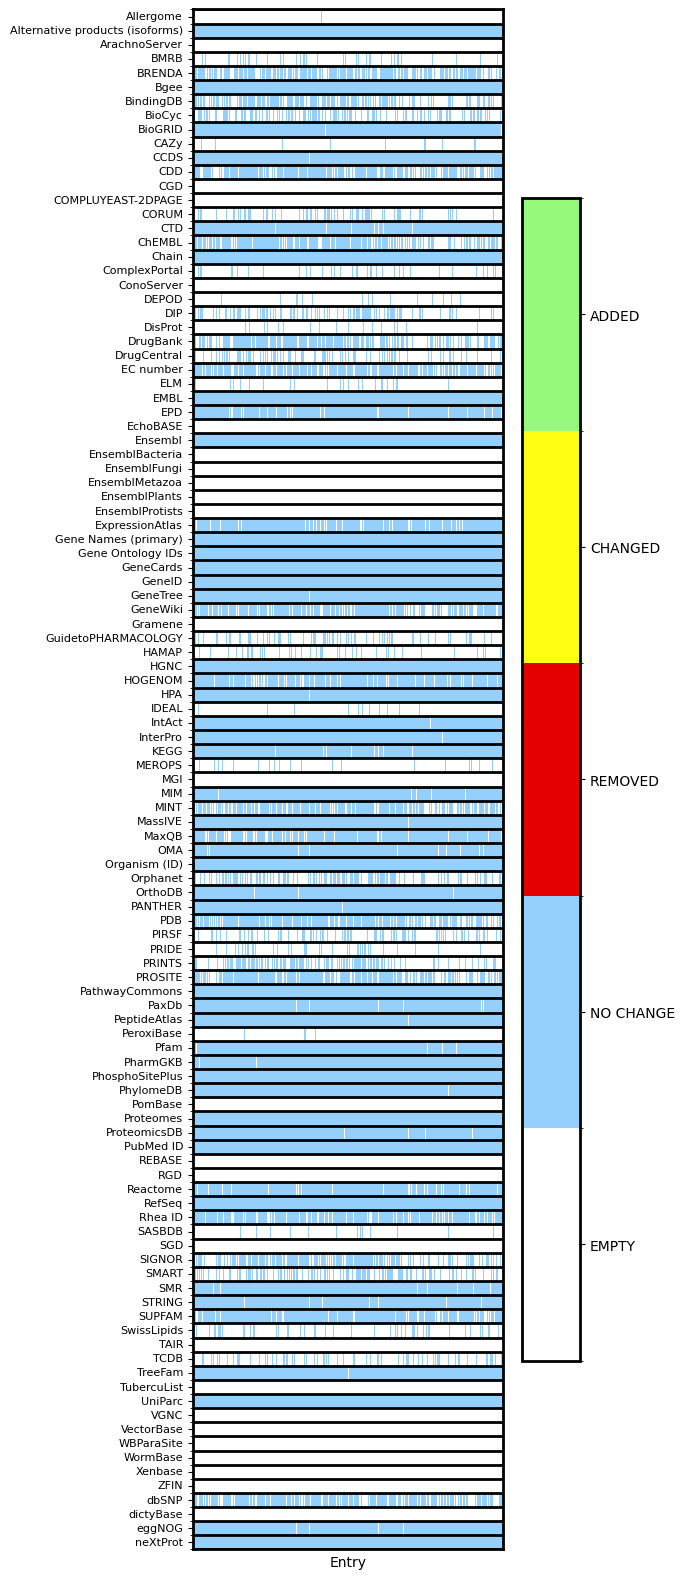

In [13]:
# Save query results to external database
df_database = df_query_results.reset_index(drop=True).drop_duplicates()
if compare:
    try:
        df_previous = pd.read_csv(
            f"{database_dirpath}/{UNIPROT_DB_TAG}_{GEM_NAME}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=["Entry"])
    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    df_comparision = compare_tables(
        df_previous.set_index("Entry"), df_database.set_index("Entry")
    )
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)


if overwrite:
    df_database.to_csv(f"{database_dirpath}/{UNIPROT_DB_TAG}_{GEM_NAME}.tsv", sep="\t")
else:
    df_database.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{UNIPROT_DB_TAG}_{GEM_NAME}.tsv", sep="\t"
    )
df_database

## Map results to model
### Genes

In [14]:
use_query_results = True
if use_query_results:
    df_model = pd.DataFrame.from_dict(
        {"From": model_search_mapping},
        orient="columns",
    )
    df_model.index.name = annotation_type
    df_model = df_model.reset_index(drop=False)
    df_database = df_query_results.copy()
else:
    annotation_type = "genes"
    annotation_key = "ncbigene"
    df_model = get_annotation_df(model, annotation_type, [annotation_key])
    df_model.columns = [annotation_type, "From"]

    from_db = annotation_to_from_db[annotation_key]
    df_database = pd.read_csv(
        f"{database_dirpath}/{database_tag}_{version}.tsv",
        sep="\t",
        index_col=0,
        dtype=str,
    )

    df_database["From"] = df_database.loc[:, fromdb].str.strip(";")
    df_database = df_database.set_index("From")

df_annotations = df_model.merge(
    df_database,
    left_on="From",
    right_index=True,
    how="outer",
)
df_annotations = (
    df_annotations.drop(["From"], axis=1).drop_duplicates().set_index("genes")
)
df_annotations

,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology IDs,Chain,PubMed ID,...,HAMAP,InterPro,PANTHER,Pfam,PIRSF,PRINTS,PROSITE,SMART,SUPFAM,Proteomes
genes,,,,,,,,,,,,,,,,,,,,,
UBA6,A0AVT1,UBA6,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,6.2.1.45,NaN,UPI000004A4F7,GO:0004792; GO:0004839; GO:0005524; GO:0005737...,"CHAIN 1..1052; /note=""Ubiquitin-like modifier-...",15202508; 17597759; 14702039; 17974005; 158156...,...,NaN,IPR032420;IPR032418;IPR042302;IPR045886;IPR000...,PTHR10953:SF162;PTHR10953;,PF16191;PF16190;PF09358;PF00899;PF10585;,NaN,PR01849;,NaN,SM00985;,SSF69572;,UP000005640: Chromosome 4
PGP,A6NDG6,PGP,9606,ALTERNATIVE PRODUCTS:,3.1.3.21; 3.1.3.48,RHEA:10684 RHEA:46084 RHEA:66372,UPI00000473F8,GO:0000121; GO:0000287; GO:0004725; GO:0005737...,"CHAIN 1..321; /note=""Glycerol-3-phosphate phos...",15616553; 215071; 21269460; 26755581,...,NaN,IPR036412;IPR006357;IPR023214;IPR006349;,PTHR19288;PTHR19288:SF92;,PF13344;PF13242;,PIRSF000915;,NaN,NaN,NaN,SSF56784;,UP000005640: Chromosome 16
MFSD2B,A6NFX1,MFSD2B,9606,ALTERNATIVE PRODUCTS:,NaN,RHEA:38667 RHEA:38671 RHEA:70207,UPI000047F9C2,GO:0003376; GO:0005886; GO:0006869; GO:0008643...,"CHAIN 1..504; /note=""Sphingosine-1-phosphate t...",15815621; 18694395; 29045386; 29563527,...,NaN,IPR039672;IPR036259;,PTHR11328;PTHR11328:SF30;,PF13347;,NaN,NaN,NaN,NaN,SSF103473;,UP000005640: Chromosome 2
ACOT7,O00154,ACOT7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.2.2,RHEA:16645 RHEA:30143 RHEA:30135 RHEA:40139 RH...,UPI000012674F,GO:0000062; GO:0005654; GO:0005739; GO:0005829...,"CHAIN 1..380; /note=""Cytosolic acyl coenzyme A...",10578051; 12435388; 14702039; 16710414; 154893...,...,NaN,IPR040170;IPR033120;IPR029069;IPR006683;,PTHR11049;PTHR11049:SF27;,PF03061;,NaN,NaN,PS51770;,NaN,SSF54637;,UP000005640: Chromosome 1
CLIC1,O00299,CLIC1,9606,ALTERNATIVE PRODUCTS:,NaN,NaN,UPI000011785A,GO:0005254; GO:0005615; GO:0005634; GO:0005635...,"CHAIN 2..241; /note=""Chloride intracellular ch...",9139710; 10191309; 10384126; 14656967; 1457440...,...,NaN,IPR002946;IPR030259;IPR010987;IPR036282;IPR040...,PTHR45476:SF2;PTHR45476;,PF13410;PF13409;,NaN,PR01263;,PS50405;,NaN,SSF47616;SSF52833;,UP000005640: Chromosome 6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLC12A7,Q9Y666,SLC12A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,NaN,RHEA:72427,UPI0000141815,GO:0005886; GO:0006811; GO:0006884; GO:0007268...,"CHAIN 1..1083; /note=""Solute carrier family 12...",10347194; 15372022; 15489334; 11214971; 179740...,...,NaN,IPR004841;IPR000076;IPR018491;IPR004842;,PTHR11827:SF47;PTHR11827;,PF00324;PF03522;,NaN,PR01081;,NaN,NaN,NaN,UP000005640: Chromosome 5
SLC22A7,Q9Y694,SLC22A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,NaN,RHEA:72043 RHEA:76207 RHEA:76211 RHEA:76215 RH...,UPI000006F307,GO:0005829; GO:0005886; GO:0006805; GO:0006811...,"CHAIN 1..548; /note=""Solute carrier family 22 ...",14702039; 14574404; 15489334; 11327718; 120235...,...,NaN,IPR011701;IPR020846;IPR036259;IPR004749;,PTHR24064;PTHR24064:SF33;,PF07690;,NaN,NaN,PS50850;,NaN,SSF103473;,UP000005640: Chromosome 6
CLIC4,Q9Y696,CLIC4,9606,ALTERNATIVE PRODUCTS:,NaN,NaN,UPI0000127AC9,GO:0001525; GO:0001886; GO:0005254; GO:0005737...,"CHAIN 2..253; /note=""Chloride intracellular ch...",10070163; 10191309; 11230166; 15489334; 107931...,...,NaN,IPR002946;IPR010987;IPR036282;IPR040079;IPR004...,PTHR45476:SF5;PTHR45476;,PF13409;,NaN,PR01263;,PS50405;,NaN,SSF47616;SSF52833;,UP000005640: Chromosome 1


### Format UniProt information for annotation files
#### Map to chosen MIRIAMs
As formatting may be needed for some MIRIAMS, keep it simple for now until formatting methods are developed. 

In [15]:
# Keeping it simple for now, group items regardless of isoforms for the time being
uniprot_miriam_mapping = get_label_miriam_mapping_UniProt(
    get_query_fields_UniProt(miriam_only=True)
)
uniprot_miriam_mapping["Proteomes"]  = "chromosome"
df_annotations = df_annotations.loc[:, list(uniprot_miriam_mapping)].rename(
    uniprot_miriam_mapping, axis=1
)
uniprot_columns = ["uniprot", "uniprot.isoform", "uniprot.chain"]
# For the most part, these columns do not require any reformatting or are easy to work with.
annotation_columns = [
    "hgnc.symbol",
    "ec-code",
    "taxonomy",
    "uniparc",
    # Gene Ontology (GO)
    "go",
    # Sequence
    "ccds",
    "ena.embl",
    "refseq",
    # 3D Structure
    "bmrb",
    "pdb",
    "sasbdb",
    "smr",
    # Protein-protein interaction
    "biogrid",
    "complexportal",
    "dip",
    # Chemistry databases
    "chembl.target",
    "drugbank",
    "iuphar.receptor",
    # Protein family/group databases
    "cazy",
    "ideal",
    "merops",
    "peroxibase",
    "tcdb",
    # Genetic variation/Polymorphism and mutation databases
    "dbsnp",
    # Proteomic databases
    "proteomicsdb.protein",
    # Genome annotation databases
    "ensembl",
    "ncbigene",
    ## Organism-specific
    "kegg.genes",
    "genecards",
    "hgnc",
    "hpa",
    "mim",
    "nextprot",
    "orphanet",
    "pharmgkb.gene",
    # Phylogenomic databases
    "eggnog",
    "genetree",
    "hogenom",
    "oma.grp",
    "orthodb",
    "treefam",
    # Enzyme and pathway databases
    "biocyc",
    "brenda",
    "reactome",
    # Miscellaneous databases
    "genewiki",
    # Gene expression databases
    "bgee.gene",
    ## Family and domain databases
    "cdd",
    "disprot",
    "hamap",
    "interpro",
    "panther.family",
    "pfam",
    "pirsf",
    "prints",
    "prosite",
    "smart",
    "supfam",
    "chromosome"
]
df_annotations["chromosome"] = df_annotations["chromosome"].apply(lambda x: x.split(" ")[-1])

df_annotations = df_annotations.loc[:, uniprot_columns + annotation_columns]
print(f"Fields searched: {df_annotations.shape[1]}")
all_na = df_annotations.T[df_annotations.isna().all(axis=0)].index
annotation_columns = [x for x in annotation_columns if x not in all_na]
df_annotations = df_annotations.dropna(how="all", axis=1)
print(f"Empty dropped: {len(all_na)}")
print(f"Remaining: {df_annotations.shape[1]}")

df_annotations

Fields searched: 61
Empty dropped: 0
Remaining: 61


,uniprot,uniprot.isoform,uniprot.chain,hgnc.symbol,ec-code,taxonomy,uniparc,go,ccds,ena.embl,...,hamap,interpro,panther.family,pfam,pirsf,prints,prosite,smart,supfam,chromosome
genes,,,,,,,,,,,,,,,,,,,,,
UBA6,A0AVT1,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..1052; /note=""Ubiquitin-like modifier-...",UBA6,6.2.1.45,9606,UPI000004A4F7,GO:0004792; GO:0004839; GO:0005524; GO:0005737...,CCDS3516.1 [A0AVT1-1];,AY359880;EF623993;AB014773;AK001670;AK094969;A...,...,NaN,IPR032420;IPR032418;IPR042302;IPR045886;IPR000...,PTHR10953:SF162;PTHR10953;,PF16191;PF16190;PF09358;PF00899;PF10585;,NaN,PR01849;,NaN,SM00985;,SSF69572;,4
PGP,A6NDG6,ALTERNATIVE PRODUCTS:,"CHAIN 1..321; /note=""Glycerol-3-phosphate phos...",PGP,3.1.3.21; 3.1.3.48,9606,UPI00000473F8,GO:0000121; GO:0000287; GO:0004725; GO:0005737...,CCDS42104.1;,AC009065;CH471112;,...,NaN,IPR036412;IPR006357;IPR023214;IPR006349;,PTHR19288;PTHR19288:SF92;,PF13344;PF13242;,PIRSF000915;,NaN,NaN,NaN,SSF56784;,16
MFSD2B,A6NFX1,ALTERNATIVE PRODUCTS:,"CHAIN 1..504; /note=""Sphingosine-1-phosphate t...",MFSD2B,NaN,9606,UPI000047F9C2,GO:0003376; GO:0005886; GO:0006869; GO:0008643...,CCDS86824.1;,AC104665;AC008073;BX357394;,...,NaN,IPR039672;IPR036259;,PTHR11328;PTHR11328:SF30;,PF13347;,NaN,NaN,NaN,NaN,SSF103473;,2
ACOT7,O00154,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..380; /note=""Cytosolic acyl coenzyme A...",ACOT7,3.1.2.2,9606,UPI000012674F,GO:0000062; GO:0005654; GO:0005739; GO:0005829...,CCDS30573.1 [O00154-7];CCDS65.1 [O00154-1];CCD...,D88894;AB074415;AB074416;AB074417;AB074418;AB0...,...,NaN,IPR040170;IPR033120;IPR029069;IPR006683;,PTHR11049;PTHR11049:SF27;,PF03061;,NaN,NaN,PS51770;,NaN,SSF54637;,1
CLIC1,O00299,ALTERNATIVE PRODUCTS:,"CHAIN 2..241; /note=""Chloride intracellular ch...",CLIC1,NaN,9606,UPI000011785A,GO:0005254; GO:0005615; GO:0005634; GO:0005635...,CCDS4719.1;,U93205;AF034607;AF109197;AJ012008;CR542071;AF1...,...,NaN,IPR002946;IPR030259;IPR010987;IPR036282;IPR040...,PTHR45476:SF2;PTHR45476;,PF13410;PF13409;,NaN,PR01263;,PS50405;,NaN,SSF47616;SSF52833;,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLC12A7,Q9Y666,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..1083; /note=""Solute carrier family 12...",SLC12A7,NaN,9606,UPI0000141815,GO:0005886; GO:0006811; GO:0006884; GO:0007268...,CCDS34129.1 [Q9Y666-1];,AF105365;AC116351;BC007760;BC098390;AK024493;A...,...,NaN,IPR004841;IPR000076;IPR018491;IPR004842;,PTHR11827:SF47;PTHR11827;,PF00324;PF03522;,NaN,PR01081;,NaN,NaN,NaN,5
SLC22A7,Q9Y694,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..548; /note=""Solute carrier family 22 ...",SLC22A7,NaN,9606,UPI000006F307,GO:0005829; GO:0005886; GO:0006805; GO:0006811...,CCDS4892.1 [Q9Y694-2];CCDS4893.2 [Q9Y694-1];,AF097518;AF210455;AY050498;AK290796;AK290806;E...,...,NaN,IPR011701;IPR020846;IPR036259;IPR004749;,PTHR24064;PTHR24064:SF33;,PF07690;,NaN,NaN,PS50850;,NaN,SSF103473;,6
CLIC4,Q9Y696,ALTERNATIVE PRODUCTS:,"CHAIN 2..253; /note=""Chloride intracellular ch...",CLIC4,NaN,9606,UPI0000127AC9,GO:0001525; GO:0001886; GO:0005254; GO:0005737...,CCDS256.1;,AF097330;AF109196;AL117424;BC012444;,...,NaN,IPR002946;IPR010987;IPR036282;IPR040079;IPR004...,PTHR45476:SF5;PTHR45476;,PF13409;,NaN,PR01263;,PS50405;,NaN,SSF47616;SSF52833;,1


In [16]:
df_isoforms_chains = df_annotations.loc[:, uniprot_columns].copy()
df_isoforms_chains = parse_isoforms_UniProt(df_isoforms_chains, add_canonical=True)
df_isoforms_chains = parse_chains_UniProt(df_isoforms_chains)
df_isoforms_chains

,uniprot,uniprot.isoform,uniprot.chain,uniprot.canonical
genes,,,,
UBA6,A0AVT1,A0AVT1-1;A0AVT1-2;A0AVT1-3;A0AVT1-4,PRO_0000277797,A0AVT1-1
PGP,A6NDG6,,PRO_0000316888,A6NDG6
MFSD2B,A6NFX1,,PRO_0000341260,A6NFX1
ACOT7,O00154,O00154-1;O00154-2;O00154-3;O00154-4;O00154-5;O...,PRO_0000053806,O00154-1
CLIC1,O00299,,PRO_0000144201,O00299
...,...,...,...,...
SLC12A7,Q9Y666,Q9Y666-1;Q9Y666-2,PRO_0000178039,Q9Y666-1
SLC22A7,Q9Y694,Q9Y694-1;Q9Y694-2;Q9Y694-3;Q9Y694-4,PRO_0000317481,Q9Y694-1
CLIC4,Q9Y696,,PRO_0000144210,Q9Y696


genes: 693
uniprot: 693
uniprot.isoform: 0
uniprot.chain: 730
hgnc.symbol: 694
ec-code: 495
taxonomy: 1
uniparc: 693
go: 5408
ccds: 1207
ena.embl: 7392
refseq: 2098
bmrb: 72
pdb: 9844
sasbdb: 31
smr: 675
biogrid: 695
complexportal: 245
dip: 198
chembl.target: 460
drugbank: 2060
iuphar.receptor: 157
cazy: 18
ideal: 26
merops: 35
peroxibase: 11
tcdb: 134
dbsnp: 4442
proteomicsdb.protein: 1504
ensembl: 2074
ncbigene: 697
kegg.genes: 671
genecards: 694
hgnc: 694
hpa: 692
mim: 1167
nextprot: 693
orphanet: 478
pharmgkb.gene: 688
eggnog: 533
genetree: 632
hogenom: 509
oma.grp: 661
orthodb: 499
treefam: 533
biocyc: 266
brenda: 384
reactome: 1002
genewiki: 526
bgee.gene: 692
cdd: 559
disprot: 35
hamap: 89
interpro: 1776
panther.family: 1178
pfam: 667
pirsf: 138
prints: 190
prosite: 378
smart: 164
supfam: 302
chromosome: 24


,genes,uniprot,uniprot.isoform,uniprot.chain,hgnc.symbol,ec-code,taxonomy,uniparc,go,ccds,...,hamap,interpro,panther.family,pfam,pirsf,prints,prosite,smart,supfam,chromosome
0,UBA6,A0AVT1,NaN,PRO_0000277797,UBA6,6.2.1.45,9606,UPI000004A4F7,0004792;0004839;0005524;0005737;0005829;000651...,CCDS3516.1,...,NaN,IPR032420;IPR032418;IPR042302;IPR045886;IPR000...,PTHR10953:SF162;PTHR10953,PF16191;PF16190;PF09358;PF00899;PF10585,NaN,PR01849,NaN,SM00985,SSF69572,4
1,PGP,A6NDG6,NaN,PRO_0000316888,PGP,3.1.3.21;3.1.3.48,9606,UPI00000473F8,0000121;0000287;0004725;0005737;0006114;000665...,CCDS42104.1,...,NaN,IPR036412;IPR006357;IPR023214;IPR006349,PTHR19288;PTHR19288:SF92,PF13344;PF13242,PIRSF000915,NaN,NaN,NaN,SSF56784,16
2,MFSD2B,A6NFX1,NaN,PRO_0000341260,MFSD2B,NaN,9606,UPI000047F9C2,0003376;0005886;0006869;0008643;0015293;004662...,CCDS86824.1,...,NaN,IPR039672;IPR036259,PTHR11328;PTHR11328:SF30,PF13347,NaN,NaN,NaN,NaN,SSF103473,2
3,ACOT7,O00154,NaN,PRO_0000053806,ACOT7,3.1.2.2,9606,UPI000012674F,0000062;0005654;0005739;0005829;0006637;001593...,CCDS30573.1;CCDS65.1;CCDS66.1;CCDS67.1,...,NaN,IPR040170;IPR033120;IPR029069;IPR006683,PTHR11049;PTHR11049:SF27,PF03061,NaN,NaN,PS51770,NaN,SSF54637,1
4,CLIC1,O00299,NaN,PRO_0000144201,CLIC1,NaN,9606,UPI000011785A,0005254;0005615;0005634;0005635;0005737;000573...,CCDS4719.1,...,NaN,IPR002946;IPR030259;IPR010987;IPR036282;IPR040...,PTHR45476:SF2;PTHR45476,PF13410;PF13409,NaN,PR01263,PS50405,NaN,SSF47616;SSF52833,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,SLC12A7,Q9Y666,NaN,PRO_0000178039,SLC12A7,NaN,9606,UPI0000141815,0005886;0006811;0006884;0007268;0008519;001537...,CCDS34129.1,...,NaN,IPR004841;IPR000076;IPR018491;IPR004842,PTHR11827:SF47;PTHR11827,PF00324;PF03522,NaN,PR01081,NaN,NaN,NaN,5
689,SLC22A7,Q9Y694,NaN,PRO_0000317481,SLC22A7,NaN,9606,UPI000006F307,0005829;0005886;0006805;0006811;0008514;000992...,CCDS4892.1;CCDS4893.2,...,NaN,IPR011701;IPR020846;IPR036259;IPR004749,PTHR24064;PTHR24064:SF33,PF07690,NaN,NaN,PS50850,NaN,SSF103473,6
690,CLIC4,Q9Y696,NaN,PRO_0000144210,CLIC4,NaN,9606,UPI0000127AC9,0001525;0001886;0005254;0005737;0005739;000581...,CCDS256.1,...,NaN,IPR002946;IPR010987;IPR036282;IPR040079;IPR004...,PTHR45476:SF5;PTHR45476,PF13409,NaN,PR01263,PS50405,NaN,SSF47616;SSF52833,1
691,CSNK1G3,Q9Y6M4,NaN,PRO_0000192846,CSNK1G3,2.7.11.1,9606,UPI000035B1BD,0004672;0004674;0005524;0005634;0005737;000588...,CCDS34218.1;CCDS4135.1;CCDS43355.1;CCDS59491.1...,...,NaN,IPR022247;IPR011009;IPR000719;IPR017441;IPR008271,PTHR11909:SF151;PTHR11909,PF12605;PF00069,NaN,NaN,PS00107;PS50011;PS00108,SM00220,SSF56112,5


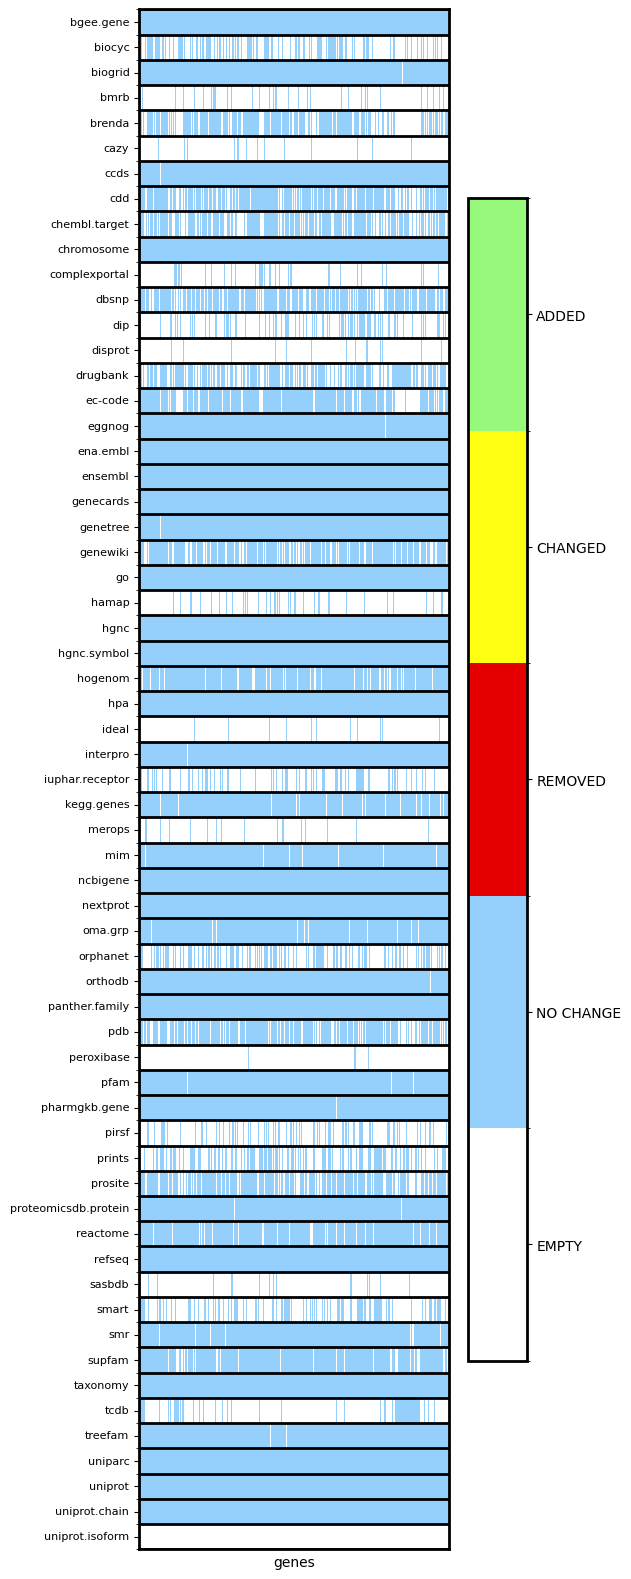

In [17]:
# Identify isoforms and chains
df_isoforms_chains = df_annotations.loc[:, uniprot_columns].copy()
df_isoforms_chains = parse_isoforms_UniProt(df_isoforms_chains, add_canonical=True)
df_isoforms_chains = parse_chains_UniProt(df_isoforms_chains)


double_check = []
for gene, (uniprot_id, isoforms) in df_isoforms_chains.loc[
    :, ["uniprot", "uniprot.isoform"]
].iterrows():
    isoforms = isoforms.split(";")
    isonum = gene.split("_AT")[-1]
    if isonum.isnumeric() and f"{uniprot_id}-{isonum}" in isoforms:
        df_isoforms_chains.loc[gene, "uniprot.isoform"] = f"{uniprot_id}-{isonum}"
    else:
        double_check += [gene]
        df_isoforms_chains.loc[gene, "uniprot.isoform"] = float("nan")

df_annotations["uniprot.isoform"] = df_isoforms_chains["uniprot.isoform"]
df_annotations["uniprot.chain"] = df_isoforms_chains["uniprot.chain"]


for idx, row in df_annotations.loc[:, annotation_columns].iterrows():
    uniprot_id, isoform_id = df_isoforms_chains.loc[
        idx, ["uniprot", "uniprot.isoform"]
    ].fillna("")
    # No isoform ID set, just aggregate all without regards to isoform.
    row = row.apply(lambda x: get_isoform_value_from_entry_UniProt(x, isoform_id))
    # A duplicate reindexing error may here may mean duplicate columns in annotation column values
    df_annotations.loc[idx, annotation_columns] = row.values
df_annotations = df_annotations.reset_index(drop=False)
# Clean up other annotations
keys = ["rhea", "go", "hgnc"]
for key in keys:
    if key in df_annotations.columns:
        df_annotations[key] = (
            df_annotations[key]
            .fillna("")
            .apply(
                lambda x: build_string(
                    [s.lstrip(f"{key.upper()}:") for s in split_string(x)]
                )
            )
        )

if compare:
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{UNIPROT_DB_TAG}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type])
    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)


if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        f"{annotation_dirpath}/{annotation_type}_{UNIPROT_DB_TAG}.tsv", sep="\t"
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{UNIPROT_DB_TAG}.tsv", sep="\t"
    )
df_annotations

#### Double check

In [18]:
df_annotations.set_index(annotation_type).loc[double_check]

,uniprot,uniprot.isoform,uniprot.chain,hgnc.symbol,ec-code,taxonomy,uniparc,go,ccds,ena.embl,...,hamap,interpro,panther.family,pfam,pirsf,prints,prosite,smart,supfam,chromosome
genes,,,,,,,,,,,,,,,,,,,,,
UBA6,A0AVT1,NaN,PRO_0000277797,UBA6,6.2.1.45,9606,UPI000004A4F7,0004792;0004839;0005524;0005737;0005829;000651...,CCDS3516.1,AY359880;EF623993;AB014773;AK001670;AK094969;A...,...,NaN,IPR032420;IPR032418;IPR042302;IPR045886;IPR000...,PTHR10953:SF162;PTHR10953,PF16191;PF16190;PF09358;PF00899;PF10585,NaN,PR01849,NaN,SM00985,SSF69572,4
PGP,A6NDG6,NaN,PRO_0000316888,PGP,3.1.3.21;3.1.3.48,9606,UPI00000473F8,0000121;0000287;0004725;0005737;0006114;000665...,CCDS42104.1,AC009065;CH471112,...,NaN,IPR036412;IPR006357;IPR023214;IPR006349,PTHR19288;PTHR19288:SF92,PF13344;PF13242,PIRSF000915,NaN,NaN,NaN,SSF56784,16
MFSD2B,A6NFX1,NaN,PRO_0000341260,MFSD2B,NaN,9606,UPI000047F9C2,0003376;0005886;0006869;0008643;0015293;004662...,CCDS86824.1,AC104665;AC008073;BX357394,...,NaN,IPR039672;IPR036259,PTHR11328;PTHR11328:SF30,PF13347,NaN,NaN,NaN,NaN,SSF103473,2
ACOT7,O00154,NaN,PRO_0000053806,ACOT7,3.1.2.2,9606,UPI000012674F,0000062;0005654;0005739;0005829;0006637;001593...,CCDS30573.1;CCDS65.1;CCDS66.1;CCDS67.1,D88894;AB074415;AB074416;AB074417;AB074418;AB0...,...,NaN,IPR040170;IPR033120;IPR029069;IPR006683,PTHR11049;PTHR11049:SF27,PF03061,NaN,NaN,PS51770,NaN,SSF54637,1
CLIC1,O00299,NaN,PRO_0000144201,CLIC1,NaN,9606,UPI000011785A,0005254;0005615;0005634;0005635;0005737;000573...,CCDS4719.1,U93205;AF034607;AF109197;AJ012008;CR542071;AF1...,...,NaN,IPR002946;IPR030259;IPR010987;IPR036282;IPR040...,PTHR45476:SF2;PTHR45476,PF13410;PF13409,NaN,PR01263,PS50405,NaN,SSF47616;SSF52833,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLC12A7,Q9Y666,NaN,PRO_0000178039,SLC12A7,NaN,9606,UPI0000141815,0005886;0006811;0006884;0007268;0008519;001537...,CCDS34129.1,AF105365;AC116351;BC007760;BC098390;AK024493;A...,...,NaN,IPR004841;IPR000076;IPR018491;IPR004842,PTHR11827:SF47;PTHR11827,PF00324;PF03522,NaN,PR01081,NaN,NaN,NaN,5
SLC22A7,Q9Y694,NaN,PRO_0000317481,SLC22A7,NaN,9606,UPI000006F307,0005829;0005886;0006805;0006811;0008514;000992...,CCDS4892.1;CCDS4893.2,AF097518;AF210455;AY050498;AK290796;AK290806;E...,...,NaN,IPR011701;IPR020846;IPR036259;IPR004749,PTHR24064;PTHR24064:SF33,PF07690,NaN,NaN,PS50850,NaN,SSF103473,6
CLIC4,Q9Y696,NaN,PRO_0000144210,CLIC4,NaN,9606,UPI0000127AC9,0001525;0001886;0005254;0005737;0005739;000581...,CCDS256.1,AF097330;AF109196;AL117424;BC012444,...,NaN,IPR002946;IPR010987;IPR036282;IPR040079;IPR004...,PTHR45476:SF5;PTHR45476,PF13409,NaN,PR01263,PS50405,NaN,SSF47616;SSF52833,1
